# Iterative methods for solving linear systems




Let us consider an elastic cable fixed at the extremes occupying at rest the space $[0,1]$. We apply on it a given force $f(x)$. Its displacement at the point $x$, $u(x)$ is the solution of the following problem:
$$
-u_h''(x) = f(x)\ \mathrm{ in }\ [0,1]
$$

$$
u_h(0) = 0, \quad u_h(1) = 0
$$

For the sake of simplicity we consider a uniform discretisation of the interval $[0,1]$ using $n$ equispaced *sample points* to construct a **Finite Difference Approximation**.

In [14]:
%matplotlib inline
from numpy import *
from matplotlib.pyplot import *
import numpy.linalg

n = 1000
h = 1./(n-1)

x=linspace(0,1,n)

# Central finite difference approximation

We consider the approximation

$$
-u''_i := \frac{-u_{i-1} + 2u_i - u_{i+1}}{h^2}
$$

and solve the linear system

$$
\frac{-u_{i-1} + 2u_i - u_{i+1}}{h^2} = f_i \qquad i=1,\ldots,n-2
$$

This results in a tridiagonal matrix with $n-2$ entries. We assemble all of the entries anyway, and then perform a **line elimination** to make the system solvable. This is typical of problems with **Dirichlet Boundary conditions**.

In [15]:
a = -ones((n-1,)) # Offdiagonal entries
b = 2*ones((n,)) # Diagonal entries
A = (diag(a, -1) + diag(b, 0) + diag(a, +1))
print(A)

# Now we scale it to 1/h^2
A /= h**2

print(linalg.cond(A))

[[ 2. -1.  0. ...,  0.  0.  0.]
 [-1.  2. -1. ...,  0.  0.  0.]
 [ 0. -1.  2. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  2. -1.  0.]
 [ 0.  0.  0. ..., -1.  2. -1.]
 [ 0.  0.  0. ...,  0. -1.  2.]]
406095.042648


Now let's consider a simple right hand side:

$$
f_i = x_i(1-x_i)
$$
which gives as exact solution

$$
u_{\mathrm{exact}} = \frac{x^4}{12} - \frac{x^3}{6} +\frac{x}{12}
$$


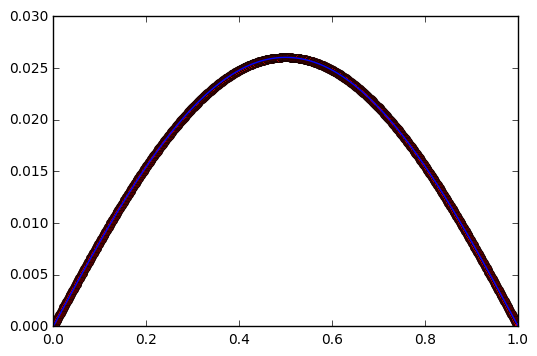

In [16]:
f =x*(1.-x)

# Imposing homogeneous BCs keeping A SPD
A[0,:] = 0
A[:,0] = 0
A[0,0] = 1.

A[:,-1] = 0
A[-1,:] = 0
A[-1,-1] = 1

f[0] = 0
f[-1] = 0

A1 = A.copy()

u = linalg.solve(A1, f)

u_ex = (x**4)/12. - (x**3)/6. + x/12.

_ = plot(x,u,'ro')
_ = plot(x,u_ex)


## Jacobi

$$ 
x_i^{k+1} = \frac{1}{A_{ii}} \times \left(b_i - \sum_{j\neq i} a_{ij}x_j^k\right)
$$



In [17]:
def jacobi(A,b,nmax=10000, eps=1e-10):
    N=len(A)
    x = zeros_like(b)
    x_old = zeros_like(b)
    tol = eps+1
    it = 0
    while (it<nmax and tol>eps):
        it += 1
        for i in range(N):
            x[i] = 1./A[i,i]*(b[i] - dot(A[i,0:i],x_old[0:i]) - dot(A[i,i+1:N],x_old[i+1:N]))
            
        res = b - dot(A,x)
        tol = numpy.linalg.norm(res,2)
        
        x_old = x.copy()
    
    print it, tol
    return x

sol_jacobi = jacobi(A,f)
    



KeyboardInterrupt: 

## Gauss-Seidel

$$ 
x_i^{k+1} = \frac{1}{A_{ii}} \times \left(b_i - \sum_{j=0}^{i-1} a_{ij}x_j^{k+1} - \sum_{j=i+1}^{N} a_{ij}x_j^k\right)
$$

In [6]:
def GS(A,b,nmax=10000, eps=1e-10):
    N=len(A)
    x = zeros_like(b)
    x_old = zeros_like(b)
    tol = eps+1
    it = 0
    while (it<nmax and tol>eps):
        it += 1
        for i in range(N):
            x[i] = 1./A[i,i]*(b[i] - dot(A[i,0:i],x[0:i]) - dot(A[i,i+1:N],x_old[i+1:N]))
            
        res = b - dot(A,x)
        tol = numpy.linalg.norm(res,2)
        
        x_old = x.copy()
    
    print it, tol
    return x

sol_gs = GS(A,f)
    


2390 9.9530299764e-11


   ## Gradient method
   $$
   {\bf r}^k = {\bf b} - A {\bf x}^k
   $$
   
   $$
   \alpha^k = \frac{{\bf r}^{k^{T}} {\bf r}^k}{{\bf r}^{k^{T}} A{\bf r}^k}
   $$
   
   $$
   {\bf x}^{k+1} = {\bf x}^k + \alpha^k {\bf r}^k
   $$
   
   ### preconditioned
   solve
   $$
   P{\bf z}^k =  {\bf r}^k
   $$
   
   $$
   \alpha^k = \frac{{\bf z}^{k^{T}} {\bf r}^k}{{\bf z}^{k^{T}} A{\bf z}^k}
   $$
 
   $$
   {\bf x}^{k+1} = {\bf x}^k + \alpha^k {\bf z}^k
   $$ 
   
   $$
   {\bf r}^{k+1} = {\bf r}^k  - \alpha^k A{\bf z}^k
   $$

In [9]:
def gradient(A,b,P,nmax=8000, eps=1e-10):
    n=len(A)
    x= zeros_like(b)
    tol = eps +1
    r = b - dot(A,x)
    it = 0
    while (it<nmax and tol>eps):
        z = linalg.solve(P,r)
        alpha = dot(r,z)/(dot(z,dot(A,z)))
        x += z*alpha
        r -= dot(A,z)*alpha
        tol = numpy.linalg.norm(r,2)
        it += 1
    print it, tol
    
gradient(A,f,identity(len(A)))
print ""
gradient(A,f,A)


3909 9.94753934189e-11

1 1.20640538134e-14


## Coniugate gradient
   
   $$
   \alpha^k = \frac{{\bf p}^{k^{T}} {\bf r}^k}{{\bf p}^{k^{T}} A{\bf p}^k}
   $$
   
      
   $$
   {\bf x}^{k+1} = {\bf x}^k + \alpha^k {\bf p}^k
   $$
   
   $$
   {\bf r}^{k+1} = {\bf r}^k - \alpha^kA {\bf p}^k
   $$

   $$
   \beta^k = \frac{(A{\bf p}^{k})^{T}{\bf r}^{k+1}}{(A{\bf p}^{k})^{T}  {\bf p}^k}
   $$
   
   $$
   {\bf p}^{k+1} = {\bf r}^{k+1} - \beta^k{\bf p}^k
   $$

   
   ### preconditioned
   
   
   $$
   \alpha^k = \frac{{\bf p}^{k^{T}} {\bf r}^k}{(A{\bf p}^{k})^{T}{\bf p}^k}
   $$
   
      
   $$
   {\bf x}^{k+1} = {\bf x}^k + \alpha^k {\bf p}^k
   $$
   
   $$
   {\bf r}^{k+1} = {\bf r}^k - \alpha^kA {\bf p}^k
   $$

$$
P{\bf z}^{k+1} = {\bf r}^{k+1}
$$

   $$
   \beta^k = \frac{(A{\bf p}^{k})^{T}{\bf z}^{k+1}}{{\bf p}^{k^T}A  {\bf p}^k}
   $$
   
   $$
   {\bf p}^{k+1} = {\bf z}^{k+1} - \beta^k{\bf p}^k
   $$


In [19]:
def CG(A,b,P, nmax=len(A), eps=1e-10):
    N=len(A)
    x = zeros_like(b)
    tol = eps + 1
    it = 0
    r = b - dot(A,x)
    rho_old = 1.
    p_old = zeros_like(b)
    while (it < nmax and tol > eps):
        it += 1
        z = linalg.solve(P,r)
        rho = dot(r,z)
        if (it > 1):
            beta = rho/rho_old
            p = z + beta*p_old
        else:
            p = z
        q = dot(A,p)
        alpha = rho/(dot(p,q))
        x += p*alpha
        r -= q*alpha
        
        p_old = p
        rho_old = rho
        
        tol = numpy.linalg.norm(r,2)
        
    print it, tol

CG(A,f,diag(diag(A)))

499 7.87545261274e-15


## compare the performances of the methods